# Решение задачи фильтрации спама с помощью наивного Баейсовского классификатора

Целью данной работы является реализация модели машинного обучения для классификации писем на предмет спама.

Датасет: Enron-Spam dataset https://www.kaggle.com/datasets/wanderfj/enron-spam. Он представляет из себя 5587 текстов на английском языке, размеченным как ham/spam (не спам/спам).

В качество самой модели был выбран Наивный Байесовский Классификатор. 

Также был проведен экксперимент для выявления лучшего способа предобработки текста и извлечения эмбедингов, после чего были проанализированы качества полученных моделей и выбрана лучшая:
1. Модель, обученная эмбеддингах, полученных с помощью Bag of Words, с предварительным стеммингом

2. Модель, обученная эмбеддингах, полученных с помощью tf-idf, с предварительным стеммингом

3. Модель, обученная эмбеддингах, полученных с помощью Bag of Words, с предварительной лемматизацией

4. Модель, обученная эмбеддингах, полученных с помощью tf-idf, с предварительной лемматизацией


Почему был выбран наивный байесовский классификатор, а именно MultinomialNB из модуля sklearn.naive_bayes?

1. Простота и высокая скорость обучения. Наивный байесовский классификатор обучается быстро, особенно на больших объемах данных. Это особенно важно в случае текстов, где количество признаков (слова) может быть очень велико.

2. Эффективность на коротких текстах. Наивный байесовский классификатор обычно работает хорошо, даже когда у вас ограниченное количество данных или когда тексты короткие. Это важно, например, в задачах анализа тональности коротких сообщений.

3. Хорошие результаты на практике. Несмотря на свою наивность и предположение о независимости признаков, MultinomialNB часто дает хорошие результаты в задачах текстовой классификации, особенно когда предположение о независимости относительно хорошо выполняется в данной задаче.

4. Работа с частотами слов. В задачах текстовой классификации часто используются частоты слов или их TF-IDF векторы. MultinomialNB хорошо работает с этими числовыми данными, так как его базовая предпосылка основана на мультиномиальном распределении, которое подходит для дискретных данных, таких как счетчики слов.



Как работает НБ-классификатор?

Мы рассчитываем оценку для каждого класса (спам/не спам) и выбираем ту, которая получилась максимальной. Для этого используем следующую формулу:

$$arg\max[P(Q_k)\prod_{i=1}^nP(x_i|Q_k)]$$


$
P(Q_k) = \cfrac{\text{число документов класса } Q_k}{\text{общее количество документов}}
$

$P(x_i|Q_k)=\cfrac{\alpha+N_{ik}}{\alpha M+N_k}$ — вхождение слова $x_i$ в документ класса $Q_k$ (со сглаживанием)*

$N_k$ — количество слов входящих в документ класса $Q_k$

М — количество слов из обучающей выборки

$N_{ik}$ — количество вхождений слова $x_i$ в документ класса $Q_k$

$\alpha$ — параметр для сглаживания

## Импортируем датасет и разобьем на объекты и таргеты

In [2]:
import pandas as pd
import numpy as np 
from sklearn.datasets import load_files

import re

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
X, y = [], []
email = load_files("/home/andrei/Python/AUD/email_classification/dataset/enron2")
email

{'data': [b'Subject: all graphics software available , cheap oem versions .\r\ngood morning ,\r\nwe we offer latest oem packages of all graphics and publishinq software from corel , macromedia , adobe and others .\r\n$ 80 adobe photoshop 8 . 0 / cs\r\n$ 140 macromedia studio mx 2004\r\n$ 120 adobe acrobat 7 . 0 professional\r\n$ 150 adobe premiere pro 1 . 5\r\n$ 90 corel desiqner 10\r\n$ 90 quickbooks 2004 professional edition\r\n$ 75 adobe pagemaker 7 . 0\r\n$ 70 xara x vl . 1\r\n$ 75 adobe audition 1 . 5\r\n$ 90 discreet 3 d studio max 7\r\n$ 115 adobe golive cs\r\n$ 135 adobe after effects 6 . 5 standard\r\n$ 45 adobe premiere elements\r\n$ 125 corel painter lx\r\n$ 80 adobe liiustrator cs\r\n$ 80 adobe indesiqn cs\r\n$ 240 adobe creative suite\r\n$ 140 adobe framemaker 7 . 1\r\n$ 50 uiead cooi 3 d production studio 1 . 0 . 1\r\n$ 90 alias motion buiider 6 professionai\r\n$ 30 quicken 2004 premier home & biz\r\n$ 30 adobe photoshop elements 3 . 0\r\n$ 110 adobe premiere pro 7 . 0\r\

In [4]:
X = np.append(X, email.data)
y = np.append(y, email.target)
X, y, len(y)

(array([b'Subject: all graphics software available , cheap oem versions .\r\ngood morning ,\r\nwe we offer latest oem packages of all graphics and publishinq software from corel , macromedia , adobe and others .\r\n$ 80 adobe photoshop 8 . 0 / cs\r\n$ 140 macromedia studio mx 2004\r\n$ 120 adobe acrobat 7 . 0 professional\r\n$ 150 adobe premiere pro 1 . 5\r\n$ 90 corel desiqner 10\r\n$ 90 quickbooks 2004 professional edition\r\n$ 75 adobe pagemaker 7 . 0\r\n$ 70 xara x vl . 1\r\n$ 75 adobe audition 1 . 5\r\n$ 90 discreet 3 d studio max 7\r\n$ 115 adobe golive cs\r\n$ 135 adobe after effects 6 . 5 standard\r\n$ 45 adobe premiere elements\r\n$ 125 corel painter lx\r\n$ 80 adobe liiustrator cs\r\n$ 80 adobe indesiqn cs\r\n$ 240 adobe creative suite\r\n$ 140 adobe framemaker 7 . 1\r\n$ 50 uiead cooi 3 d production studio 1 . 0 . 1\r\n$ 90 alias motion buiider 6 professionai\r\n$ 30 quicken 2004 premier home & biz\r\n$ 30 adobe photoshop elements 3 . 0\r\n$ 110 adobe premiere pro 7 . 0\r\nl

## Произведем предобработку текста c помощью стеммера PorterStemmer

In [5]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [6]:
def text_preprocessing_stemming(X):
    res = []
    for i in range(len(X)):
        s = str(X[i])
        s = re.sub(r'\\r\\n', ' ', s) # Убираем специальные символы
        s = re.sub('[^a-zA-Z]', ' ', s) # Убираем знаки препинания
        s = re.sub(r'\s+', ' ', s) # Заменяем все отступы на пробелы
        s = re.sub(r'^b\s+', '', s) # Убираем b в начале каждого текста

        s = s.lower()
        s = s.split()
        s = [stemmer.stem(word) for word in s if word not in stopwords.words('english')]
        s = ' '.join(s)
        res.append(s)
    return res

In [7]:
X_stemmed = text_preprocessing_stemming(X)
X_stemmed[:5]

['subject graphic softwar avail cheap oem version good morn offer latest oem packag graphic publishinq softwar corel macromedia adob other adob photoshop cs macromedia studio mx adob acrobat profession adob premier pro corel desiqn quickbook profession edit adob pagemak xara x vl adob audit discreet studio max adob goliv cs adob effect standard adob premier element corel painter lx adob liiustrat cs adob indesiqn cs adob creativ suit adob framemak uiead cooi product studio alia motion buiider professionai quicken premier home biz adob photoshop element adob premier pro learn sincer florentina',
 'subject purchas process may awar organ undergo signific organiz chang rapid pace one group heavili affect purchas due larg increas volum request staff turnov realiz caus user pain engin process quickli possibl commun chang process next week apolog inconveni appreci patienc regard question process adjust pleas contact bob hillier extens philipp bibi cto enron global technolog',
 'subject perfec

### Обучим модель на Bag of Words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

Пара слов о CountVectorizer(): из списка документов (в нашем случае писем) X_train получаем разреженную матрицу, где строки представляют документы, столбцы представляют уникальные токены (слова или n-граммы), а значения в ячейках - частоты встречаемости соответствующих токенов в каждом документе.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_stemmed, y,  random_state = 42, test_size = 0.2)

clf_pipeline1 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classificador', MultinomialNB())])

clf_pipeline1.fit(X_train, y_train)
pred1 = clf_pipeline1.predict(X_test)
probability1 = clf_pipeline1.predict_proba(X_test)

In [10]:
accuracy = accuracy_score(y_test, pred1)
precision = precision_score(y_test, pred1)
recall = recall_score(y_test, pred1)
conf_m = confusion_matrix(y_test, pred1)
accuracy, precision, recall, conf_m

(0.9906143344709898,
 0.9814814814814815,
 0.9845201238390093,
 array([[843,   6],
        [  5, 318]]))

### Обучим модель на tf-idf

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

Пара слов о TfidfVectorizer(): он преобразует текст в матрицу признаков, где строки представляют документы, столбцы - термины, а значения - их веса TF-IDF.

In [12]:
clf_pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classificador', MultinomialNB())])

clf_pipeline2.fit(X_train, y_train)
pred2 = clf_pipeline2.predict(X_test)
probability2 = clf_pipeline2.predict_proba(X_test)

In [13]:
accuracy = accuracy_score(y_test, pred2)
precision = precision_score(y_test, pred2)
recall = recall_score(y_test, pred2)
conf_m = confusion_matrix(y_test, pred2)
accuracy, precision, recall, conf_m

(0.8890784982935154,
 1.0,
 0.5975232198142415,
 array([[849,   0],
        [130, 193]]))

## Произведем предобработку текста c помощью лемматизатора WordNetLemmatizer

In [14]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
def text_preprocessing_lemmatizing(X):
    res = []
    for i in range(len(X)):
        s = str(X[i])
        s = re.sub(r'\\r\\n', ' ', s) # Убираем специальные символы
        s = re.sub(r'[^a-zA-Z]', ' ', s) # Убираем знаки препинания
        s = re.sub(r'\s+', ' ', s) # Заменяем все отступы на пробелы
        s = re.sub(r'^b\s+', '', s) # Убираем b в начале каждого текста

        s = s.lower()
        s = s.split()
        s = [lemmatizer.lemmatize(word) for word in s if word not in stopwords.words('english')]
        s = ' '.join(s)
        res.append(s)
    return res

In [16]:
X_lemmatized = text_preprocessing_lemmatizing(X)
X_lemmatized[:5]

['subject graphic software available cheap oem version good morning offer latest oem package graphic publishinq software corel macromedia adobe others adobe photoshop c macromedia studio mx adobe acrobat professional adobe premiere pro corel desiqner quickbooks professional edition adobe pagemaker xara x vl adobe audition discreet studio max adobe golive c adobe effect standard adobe premiere element corel painter lx adobe liiustrator c adobe indesiqn c adobe creative suite adobe framemaker uiead cooi production studio alias motion buiider professionai quicken premier home biz adobe photoshop element adobe premiere pro learn sincerely florentina',
 'subject purchasing process may aware organization undergoing significant organizational change rapid pace one group heavily affected purchasing due large increase volume request staff turnover realize causing user pain engineering process quickly possible communicating change process next week apologize inconvenience appreciate patience reg

### Обучим модель на Bag of Words

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_lemmatized, y,  random_state = 42, test_size = 0.2)

clf_pipeline1.fit(X_train, y_train)
pred3 = clf_pipeline1.predict(X_test)
probability3 = clf_pipeline1.predict_proba(X_test)

In [18]:
accuracy = accuracy_score(y_test, pred3)
precision = precision_score(y_test, pred3)
recall = recall_score(y_test, pred3)
conf_m = confusion_matrix(y_test, pred3)
accuracy, precision, recall, conf_m

(0.9914675767918089,
 0.9875389408099688,
 0.9814241486068112,
 array([[845,   4],
        [  6, 317]]))

### Обучим модель на tf-idf

In [19]:
clf_pipeline2.fit(X_train, y_train)
pred4 = clf_pipeline2.predict(X_test)
probability4 = clf_pipeline2.predict_proba(X_test)

In [20]:
accuracy = accuracy_score(y_test, pred4)
precision = precision_score(y_test, pred4)
recall = recall_score(y_test, pred4)
conf_m = confusion_matrix(y_test, pred4)
accuracy, precision, recall, conf_m

(0.9010238907849829,
 1.0,
 0.6408668730650154,
 array([[849,   0],
        [116, 207]]))

## Анализ полученных результатов

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является AUC-ROC — площадь под кривой ошибок (Receiver Operating Characteristic curve). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR):

$\large TPR = \frac{TP}{TP + FN}$

$\large FPR = \frac{FP}{FP + TN}$

В идеальном случае, когда классификатор не делает ошибок (FPR = 0, TPR = 1), мы получим площадь под кривой, равную единице; в противном случае, когда классификатор случайно выдает вероятности классов, AUC-ROC будет стремиться к 0.5, так как классификатор будет выдавать одинаковое количество TP и FP.
Каждая точка на графике соответствует выбору некоторого порога. Площадь под кривой в данном случае показывает качество алгоритма (больше — лучше), кроме этого, важной является крутизна самой кривой — мы хотим максимизировать TPR, минимизируя FPR, а значит, наша кривая в идеале должна стремиться к точке (0,1).

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

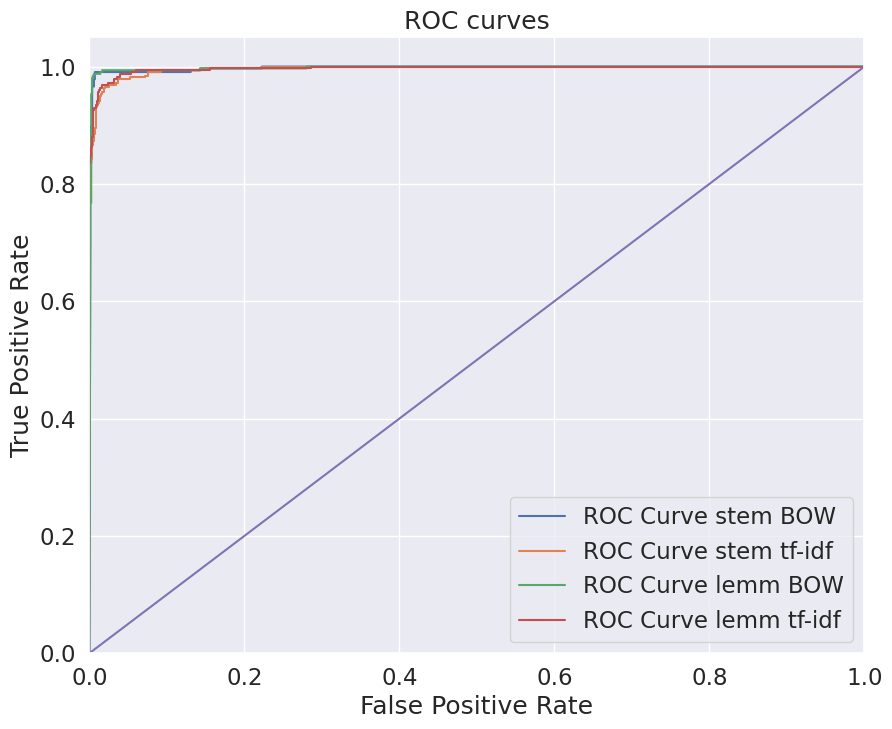

In [22]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr1, tpr1, _ = roc_curve(y_test, probability1[:, 1])
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y_test, probability2[:, 1], pos_label=1)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _ = roc_curve(y_test, probability3[:, 1], pos_label=1)
roc_auc3 = auc(fpr3, tpr3)
fpr4, tpr4, _ = roc_curve(y_test, probability4[:, 1], pos_label=1)
roc_auc4 = auc(fpr4, tpr4)

plt.plot(fpr1, tpr1, label='ROC Curve stem BOW')
plt.plot(fpr2, tpr2, label='ROC Curve stem tf-idf')
plt.plot(fpr3, tpr3, label='ROC Curve lemm BOW')
plt.plot(fpr4, tpr4, label='ROC Curve lemm tf-idf')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.savefig("ROC.png")
plt.legend()
plt.show()

## Выводы

Таким образом, была построена модель класаификации писем на спам/не спам, а также проведены эксперименты о выборе лучшего способа предобработки текста и получения эмбеддингов. Из предствленного выше графика можем увидеть, что оставляет желать лучшего лишь качество модели с лемматизацией и tf-idf. Однако не стоит забывать, что метрика recall оказывалась достаточно низкой при использовании tf-idf в обоих случаях. Можем сделать вывод, что для решения задачи классификации писем не важно, как предобрабатывать текст: лемматизацией или стеммигом, однако для получения эмбеддингов лучше использовать Bag of Words. 

## Источники  
https://habr.com/ru/companies/ods/articles/328372/  
https://www.kaggle.com/code/wanderfj/enron-spam-classifier-deploy-to-heroku-using-flask  
https://www.kaggle.com/code/vermichel/intro-to-nlp-spam-classifiier  
https://www.kaggle.com/code/calldebanjan0/spam-filtering-using-naive-bayes-classification  
https://habr.com/ru/articles/415963/  
https://www.enjoyalgorithms.com/blog/email-spam-and-non-spam-filtering-using-machine-learning  

## Тестирование

In [34]:
ham = []
spam = []
ham = np.append(ham, open('ham_example1.txt').read())
spam = np.append(spam, open('spam_example1.txt').read())
ham_preprocessed = text_preprocessing_lemmatizing(ham)
spam_preprocessed = text_preprocessing_lemmatizing(spam)

In [35]:
pred_ham = clf_pipeline1.predict_proba(ham_preprocessed)

In [36]:
pred_ham

array([[0.975752, 0.024248]])

In [31]:
pred_spam = clf_pipeline1.predict(spam_preprocessed)
pred_spam.astype(int)

array([1])